<h1>Multi-Class Classification for a synthetic [randomly/incorrecly labelled] Coursework Dataset and PCA</h1>
You are already working with image dataset - this notebook attempts to work with a subset of the coursework dataset. The procedure [steps] are similar to this week's other notebook [found <a href='pca_logistic_regression_cifar10.ipynb'>here]</a>.  The demonstrated algorithm (Logistic Regression) may not be the optimum algorithm choice for such dataset. We discussed this in the previous notebook. Furthermore, the labelled dataset is created with arbitrary labels [incorrect] - it is not created by using the annotation tool that you need to use for the Coursework dataset label creation.

A sample file name: emotionet_5_sixth_50000_250112.jpg
Shape information of two arbitrary images: (816, 459, 3) - this one is shown below, and (640, 640, 3)


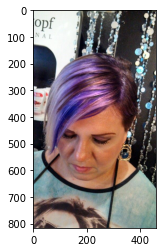

In [1]:
import pandas as pd
import numpy as np
from os import listdir
import cv2 # this package should be installed: was also required in the previous week's materials (look in that notebook for the install command)
                    # assuming this is installed by now, otherwise inside a cell type: !pip install opencv-python
import matplotlib.pyplot as plt

# Assuming you have python-opencv library installed, if not: use the following command in a cell [without the comment sign]
#!pip3 install opencv-python

# we know the path of the image files - specify it here
dir_struct = 'data/emotionet_5/sixth_50000/'
file_lst = listdir(dir_struct) # it will return all the image file names as a list
print('A sample file name: {}'.format(file_lst[5]))

# Change color to RGB from OpenCV's BGR format since this library uses BGR format [rather than RGB] for historical purposes
# an interesting perspective on why OpenCV uses BGR : https://learnopencv.com/why-does-opencv-use-bgr-color-format/
image = cv2.imread(dir_struct+file_lst[5])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print('Shape information of two arbitrary images: {} - this one is shown below, and {}'.format(image.shape, cv2.imread(dir_struct+file_lst[6]).shape))
plt.imshow(image)

<h2>Dataset creation steps</h2>
1. We will first create a sample file which will contain all the image filenames and an arbitrary label [randomly assigned between 0-9] - hair colour classification.<br/>
2. We will then read this created file with the labels and separate them into training and testing set [together with the random labels].<br/>
3. The images are also not of consistent dimension [can be seen in the above cell] - we will just resize the image to a fixed dimension [though this is not ideal way to resolve this problem at all].<br/>

In [2]:
# the 9 classes for the hair colour
class_names = ['brown', 'black', 'gray', 'blond', 'red',
               'white', 'mixed', 'other', 'not visible']

# creating the random labels for the each filename
labels = []
for i in range(len(file_lst)):
    labels.append(np.random.randint(len(class_names))) # will return a random integer between [0, 9] - not including 9

# saving the annotation file where the labels are randomly created
df = pd.DataFrame({'filename': file_lst, 'labels': labels}, columns=['filename', 'labels'])
df.to_csv('data/sample_annotation.csv', index=False)

In [3]:
# if you already have a sample annotation file, then you can format it to contain only hair colour information
# following the format of the sample_annotation.csv file created above.........
# if you want to try the remaining steps of this algorithm using your own created annotation file: start from here
df  = pd.read_csv('data/sample_annotation.csv')
print('Number of images: ', df.shape[0])
print('The proportion of the different hair colour labels: ')
# you may see equal proportion: logical since we have randomly assigned the label
df.groupby(['labels']).count()

Number of images:  1999
The proportion of the different hair colour labels: 


,filename
labels,
0,224
1,202
2,237
3,209
4,223
5,230
6,239
7,202
8,233


In [4]:
image_lst = [] # this list will hold all the images
#for i in range(1):
for i in range(df.shape[0]): # read the image one by one
    image = cv2.imread(dir_struct+df.iloc[i]['filename'])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # BGR to RGB convert
    image = cv2.resize(image, (32,32), interpolation = cv2.INTER_AREA) # resizing all images to 32x32: NOT ideal but need to be uniform in order to apply the algorithm
                                                                                                                        # this actually ensures all the features [pixel values] will be of same size
    image_lst.append(image) # appending the read image to a list

,filename,labels,image
0,emotionet_5_sixth_50000_250013.jpg,1,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
1,emotionet_5_sixth_50000_250014.jpg,7,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."


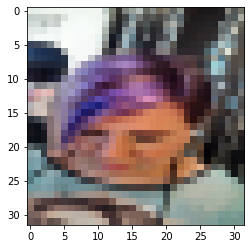

In [5]:
df['image'] = image_lst # creating a new column that holds all the images
# showing the same image that we have displayed before
# see the change because of resizing
plt.imshow(df.iloc[5]['image'])
df.head(2)

In [6]:
from sklearn.model_selection import train_test_split
# ensures equal  proportion of the multi-class labels in training/testing set
X_train, X_test, y_train, y_test = train_test_split(df.drop(['labels', 'filename'], axis=1), df['labels'], test_size=0.2, stratify=df['labels'], random_state=42)

In [7]:
# because of the structure of the array inside the image column: looks different than our other example
print('Training dataset shape: {}'.format(X_train.shape))
print('Testing dataset shape: {}'.format(X_test.shape))
X_train.head(2)

Training dataset shape: (1599, 1)
Testing dataset shape: (400, 1)


,image
735,"[[[249, 249, 249], [248, 248, 248], [246, 246,..."
1731,"[[[255, 255, 255], [255, 255, 255], [251, 253,..."


In [8]:
# manually converting it to the similar shape as our other example
X_train['image'] = X_train['image'].apply(lambda x:x.reshape(1, 3072)[0])
X_test['image'] = X_test['image'].apply(lambda x:x.reshape(1, 3072)[0])

X_train = np.reshape([x for x in X_train['image'].values], (X_train.shape[0], 3072))
X_test = np.reshape([x for x in X_test['image'].values], (X_test.shape[0], 3072))

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalization of pixel values (to [0-1] range)
X_train /= 255
X_test /= 255

In [9]:
# at this point, we have converted the image dataset to be used for Logistic Regression
# how many features are there for each image for this converted dataset?
print('Flattened training dataset shape: {}'.format(X_train.shape))
print('Flattened Testing dataset shape: {}'.format(X_test.shape))

Flattened training dataset shape: (1599, 3072)
Flattened Testing dataset shape: (400, 3072)


<strong>THE REMAINING STEPS ARE EXACTLY THE SAME AS THE PREVIOUS NOTEBOOK.</strong>
<h2>Part 1: Logistic Regression</h2>
We are applying similar training and evaluation phase that we had seen in Week 5 when Logistic Regression was introduced [the notebook link is <a href='https://github.com/mahtabhossain/comp1804-linear-regression/blob/main/logistic_regression.ipynb'>here</a>]. The only difference is: this is a multi-class classification task compared to the binary classification task that we had covered before.
<h4>Modelling</h4>

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import GridSearchCV

# just normal Logistic Regression with sklearn's default parameters
# no feature engineering, hyper-parameter tuning etc. are performed here
lr = LogisticRegression()
lr = lr.fit(X_train, y_train) # also, the categorical values are automatically detected as multi-class for sklearn's implementation
                                          # but need to be cautious depending on the choice of algorithm and its implementation details in sklearn

# THE FOLLOWING PART: GridSearch has been disabled for this notebook -- way too many features, may take a long time to converge
# Also, the choice of algorithm may not be suitable for this dataset anyway: shown only for demonstration purpose

# hyper-parameter tuning using in-built GridSearchCV
# This may take a while: good to set the max_iter parameter as well...
#param_grid=[{'C': np.logspace(-4,4,15)},
#           {'penalty': ['l2']},
#           {'solver': ['lbfgs']},
#          {'max_iter': [10000]}]

#grid = GridSearchCV(estimator=lr, param_grid=param_grid, cv=10, scoring='accuracy', refit=True) # you can change scoring function that will impact the estimator
#grid = grid.fit(X_train, y_train)
#print('Best estimator: {}\nWeights: {}, Intercept: {}\nBest params: {}\nScorer: {}'.format(grid.best_estimator_, grid.best_estimator_.coef_, grid.best_estimator_.intercept_,grid.best_params_, grid.scorer_))
#print('Available parameters for the estimator (fine-tuning): ',lr.get_params().keys())

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


<h4>Evaluation</h4>

In [11]:
# model evaluation for training set
y_train_predict = lr.predict(X_train)
print("Training SET")
print("--------------------------------------")
print('Accuracy: {:.3f}, Precision: {:.3f}, Recall: {:.3f}, F1 Score: {:.3f}'.format(accuracy_score(y_train, y_train_predict), precision_score(y_train, y_train_predict, average='macro'), recall_score(y_train, y_train_predict, average='macro'), f1_score(y_train, y_train_predict, average='macro')))
print("Confusion Matrix:\n {}".format(confusion_matrix(y_train, y_train_predict)))

# model evaluation for testing set
y_test_predict = lr.predict(X_test)

print("\nTesting SET")
print("--------------------------------------")
print('Accuracy: {:.3f}, Precision: {:.3f}, Recall: {:.3f}, F1 Score: {:.3f}'.format(accuracy_score(y_test, y_test_predict), precision_score(y_test, y_test_predict, average='macro'), recall_score(y_test, y_test_predict, average='macro'), f1_score(y_test, y_test_predict, average='macro')))
print("Confusion Matrix:\n {}".format(confusion_matrix(y_test, y_test_predict)))

Training SET
--------------------------------------
Accuracy: 0.705, Precision: 0.708, Recall: 0.705, F1 Score: 0.706
Confusion Matrix:
 [[132   3   8   5   5   6   8   7   5]
 [ 10 115   5   2   5   2  11   3   9]
 [  7   4 138   6   4  11  11   2   7]
 [  7   5   5 116   7   6   9   6   6]
 [  9   5   5   6 124   7  10   4   8]
 [  7   2   7   5   4 136   5   7  11]
 [  9   3   8   9   7   4 135  11   5]
 [  8   4  12   6   9   5   6 107   5]
 [  3   8  15   6   7   6   9   7 125]]

Testing SET
--------------------------------------
Accuracy: 0.125, Precision: 0.130, Recall: 0.124, F1 Score: 0.126
Confusion Matrix:
 [[4 4 5 3 3 8 4 6 8]
 [5 4 3 3 6 2 6 4 7]
 [7 3 8 1 4 5 8 6 5]
 [7 4 5 6 5 0 8 2 5]
 [3 7 3 1 7 9 6 3 6]
 [4 6 9 3 4 5 7 2 6]
 [7 5 6 4 3 7 6 6 4]
 [4 4 9 1 5 5 3 4 5]
 [8 4 1 4 6 8 4 6 6]]


ROC AUC (Training: Class 0 vs Rest)=0.953
ROC AUC (Testing: Class 0 vs Rest)=0.481


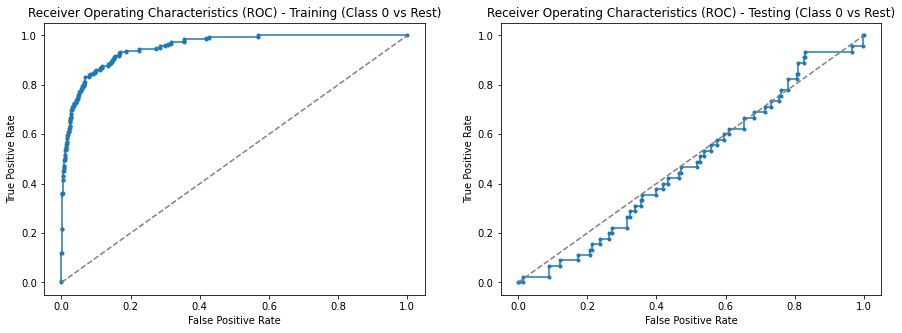

In [12]:
# this part is for the ROC curve
# since we have 10 different classes: we have only shown the curve using class 0 vs rest of the class
# the others can be shown in similar way or even plot inside the same graph
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# specify the class for which you want to view the ROC
class_number = 0

# predict probabilities
lr_probs_train = lr.predict_proba(X_train)
lr_probs_test = lr.predict_proba(X_test)

# roc curve statistics [false and true positive rates] for classes
fpr_train = {}
tpr_train = {}
fpr_test = {}
tpr_test = {}
thresh_train ={}
thresh_test = {}

# true positive rate and false positive rate for all classes: One vs Rest Classifier
for i in range(len(class_names)):    
    fpr_train[i], tpr_train[i], thresh_train[i] = roc_curve(y_train, lr_probs_train[:,i], pos_label=i)
    fpr_test[i], tpr_test[i], thresh_test[i] = roc_curve(y_test, lr_probs_test[:,i], pos_label=i)

print('ROC AUC (Training: Class {} vs Rest)={:.3f}'.format(class_number, auc(fpr_train[class_number], tpr_train[class_number])))
print('ROC AUC (Testing: Class {} vs Rest)={:.3f}'.format(class_number, auc(fpr_test[class_number], tpr_test[class_number])))
  
# plot the roc curve for the training set: shown only regarding Class 0
_ = plt.figure(figsize=(15, 5))
ax1 =plt.subplot(121)
_ = ax1.plot(fpr_train[0], tpr_train[0], marker='.') # change the index here to view Class 1 vs Rest, Class 2 vs Rest, etc.
_ = ax1.plot([0,1], [0, 1], 'gray', linestyle='--', marker='')
_ = ax1.set_title('Receiver Operating Characteristics (ROC) - Training (Class {} vs Rest)'.format(class_number))
_ = ax1.set_xlabel('False Positive Rate')
_ = ax1.set_ylabel('True Positive Rate')

# plot the roc curve for the testing set: shown only regarding Class 0
ax2 = plt.subplot(122)
_ = ax2.plot(fpr_test[0], tpr_test[0], marker='.')
_ = ax2.plot([0,1], [0, 1], 'gray', linestyle='--', marker='')
_ = ax2.set_title('Receiver Operating Characteristics (ROC) - Testing (Class {} vs Rest)'.format(class_number))
_ = ax2.set_xlabel('False Positive Rate')
_ = ax2.set_ylabel('True Positive Rate')

<h2>Part 2: Logistic Regression with Principal Component Analysis (PCA)</h2>
How do you feel about the number of features used above? Furthermore, there was no feature engineering (i.e., transformation of the features, dropping correlated features etc.). Following a similar feature-by-feature analysis that we have performed in our previous Logistic Regression notebook seems impractical - there are too many features to consider. By applying CNN, you could extract 'important' features by the algorithm itself [convolution operators, cascading layers, regularization, etc.]. In this part, we will apply PCA to address the 'curse of dimensionality' issue in order to apply Logistic Regression:<br/>
- We will transform the features along principal components [maximising the variances along them] without even using any knowledge about the output [unsupervised].<br/>
- The original features will be transformed in a way that their variances could be explained by the transformed features.<br/>
- Speed up algorithm's convergence [less feature] but still capturing the 'same' information. It (the transformation) can also help to reduce 'noise' if the original features are noisy measurement.

<h4>Selection of Principal Components</h4>
In this part, we will select the number of principal components that capture the majority of the explained variance of the original features. As can be seen below, using 650, 250 and 100 number of principal components explain 99%, 96% and 90% of the variance. We selected 250 - the original feature will then be projected into these 250 components/axes [new or transformed features].

In [13]:
from sklearn.decomposition import PCA

# checking with various n_components of PCA
# and storing the result -- cumulative variance explained by the transformed features
comp_num_lst = [2, 10, 20, 30, 50, 100, 250, 650]
var_exp_lst = []

for comp_num in comp_num_lst:
    pca_cifar = PCA(n_components=comp_num)
    pca_cifar_transform = pca_cifar.fit_transform(X_train)
    var_exp_lst.append(np.sum(pca_cifar.explained_variance_ratio_))

Explained Variances: {2: 0.40500623, 10: 0.6492495, 20: 0.7463423, 30: 0.7939773, 50: 0.84690577, 100: 0.9074351, 250: 0.9629105, 650: 0.99349153}


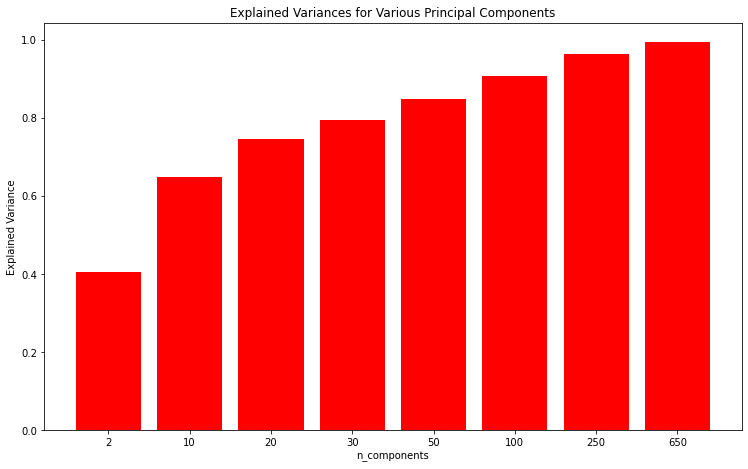

In [14]:
ind = [i for i in range(len(comp_num_lst))]

_ = plt.figure(figsize=(12.5, 7.5))
ax1 =plt.subplot(111)
_ = ax1.set_xticks(ind)
_ = ax1.set_xticklabels(comp_num_lst)
_ = ax1.bar(ind, var_exp_lst, width=0.8, color='red')
_ = ax1.set_title('Explained Variances for Various Principal Components')
_ = ax1.set_xlabel('n_components')
_ = ax1.set_ylabel('Explained Variance')

print('Explained Variances: {}'.format(dict(zip(comp_num_lst, var_exp_lst))))
plt.show()

<h4>Modelling</h4>

In [15]:
from sklearn.pipeline import make_pipeline

# creating a pipeline: first PCA() and then the classifier
# PCA's n_component can be set using the analysis above: note that here again GridSearchCV could be used to find n_components for PCA
pipeline_lr = make_pipeline(PCA(n_components=250), LogisticRegression())
pipeline_lr = pipeline_lr.fit(X_train, y_train)
#print('Weights: {}'.format(pipeline_lr['logisticregression'].coef_))

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


<h4>Evaluation</h4>
This part's steps are exactly the same as the previous Evaluation - just reproduced for the new classifier.

In [16]:
# model evaluation for training set
y_train_predict = pipeline_lr.predict(X_train)
print("Training SET")
print("--------------------------------------")
print('Accuracy: {:.3f}, Precision: {:.3f}, Recall: {:.3f}, F1 Score: {:.3f}'.format(accuracy_score(y_train, y_train_predict), precision_score(y_train, y_train_predict, average='macro'), recall_score(y_train, y_train_predict, average='macro'), f1_score(y_train, y_train_predict, average='macro')))
print("Confusion Matrix:\n {}".format(confusion_matrix(y_train, y_train_predict)))

# model evaluation for testing set
y_test_predict = pipeline_lr.predict(X_test)

print("\nTesting SET")
print("--------------------------------------")
print('Accuracy: {:.3f}, Precision: {:.3f}, Recall: {:.3f}, F1 Score: {:.3f}'.format(accuracy_score(y_test, y_test_predict), precision_score(y_test, y_test_predict, average='macro'), recall_score(y_test, y_test_predict, average='macro'), f1_score(y_test, y_test_predict, average='macro')))
print("Confusion Matrix:\n {}".format(confusion_matrix(y_test, y_test_predict)))

Training SET
--------------------------------------
Accuracy: 0.502, Precision: 0.504, Recall: 0.503, F1 Score: 0.503
Confusion Matrix:
 [[91 11 15 14  6 19  8  8  7]
 [12 81  7  5 10  8 16 11 12]
 [ 8 12 96 10  9 19 13 13 10]
 [11  5  9 87 14  6 12 11 12]
 [10  8 14 13 88  9 16 10 10]
 [ 8  8 12  7 15 95 16 10 13]
 [15  5 17 14 14 11 90  9 16]
 [ 8  7 19  7  8 10  8 83 12]
 [ 6 12 15 12 12  5 18 14 92]]

Testing SET
--------------------------------------
Accuracy: 0.115, Precision: 0.115, Recall: 0.115, F1 Score: 0.115
Confusion Matrix:
 [[4 5 2 6 5 7 5 6 5]
 [3 5 2 5 6 3 7 2 7]
 [8 4 5 2 4 5 8 4 7]
 [6 3 3 5 8 0 4 5 8]
 [2 4 4 3 7 6 6 5 8]
 [3 6 9 6 3 7 4 3 5]
 [8 4 6 6 4 6 5 6 3]
 [4 3 9 3 6 5 3 3 4]
 [5 4 2 5 7 8 8 3 5]]


ROC AUC (Training: Class 0 vs Rest)=0.858
ROC AUC (Testing: Class 0 vs Rest)=0.505


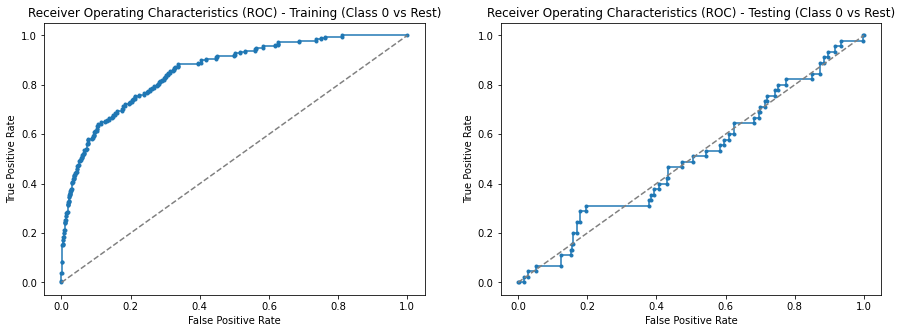

In [17]:
# this part is for the ROC curve
# since we have 10 different classes: we have only shown the curve using class 0 vs rest of the class
# the others can be shown in similar way or even plot inside the same graph
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# specify the class for which you want to view the ROC
class_number = 0

# predict probabilities
lr_probs_train = pipeline_lr.predict_proba(X_train)
lr_probs_test = pipeline_lr.predict_proba(X_test)

# roc curve statistics [false and true positive rates] for classes
fpr_train = {}
tpr_train = {}
fpr_test = {}
tpr_test = {}
thresh_train ={}
thresh_test = {}

# true positive rate and false positive rate for all classes: One vs Rest Classifier
for i in range(len(class_names)):    
    fpr_train[i], tpr_train[i], thresh_train[i] = roc_curve(y_train, lr_probs_train[:,i], pos_label=i)
    fpr_test[i], tpr_test[i], thresh_test[i] = roc_curve(y_test, lr_probs_test[:,i], pos_label=i)

print('ROC AUC (Training: Class {} vs Rest)={:.3f}'.format(class_number, auc(fpr_train[class_number], tpr_train[class_number])))
print('ROC AUC (Testing: Class {} vs Rest)={:.3f}'.format(class_number, auc(fpr_test[class_number], tpr_test[class_number])))
  
# plot the roc curve for the training set: shown only regarding Class 0
_ = plt.figure(figsize=(15, 5))
ax1 =plt.subplot(121)
_ = ax1.plot(fpr_train[0], tpr_train[0], marker='.') # change the index here to view Class 1 vs Rest, Class 2 vs Rest, etc.
_ = ax1.plot([0,1], [0, 1], 'gray', linestyle='--', marker='')
_ = ax1.set_title('Receiver Operating Characteristics (ROC) - Training (Class {} vs Rest)'.format(class_number))
_ = ax1.set_xlabel('False Positive Rate')
_ = ax1.set_ylabel('True Positive Rate')

# plot the roc curve for the testing set: shown only regarding Class 0
ax2 = plt.subplot(122)
_ = ax2.plot(fpr_test[0], tpr_test[0], marker='.')
_ = ax2.plot([0,1], [0, 1], 'gray', linestyle='--', marker='')
_ = ax2.set_title('Receiver Operating Characteristics (ROC) - Testing (Class {} vs Rest)'.format(class_number))
_ = ax2.set_xlabel('False Positive Rate')
_ = ax2.set_ylabel('True Positive Rate')

<h2>Conclusion</h2>
Just to repeat again, this notebook is just created to help you to work with Coursework image dataset. Note that, there are multiple assumptions undertaken here - especially in terms of randomly created dataset labels [which will be quite important for your developed algorithm's performance]. This is apparent in the obtained results - poor generalization performance since incorrect/random labelling of data [the patterns were not correctly identified].<br/>

Also, remember the not so optimum choice of algorithm here, and the various image augmentation techniques that could have been explored. We just took one of the classification task and tried to show a sample machine learning (ML) workflow based on a synthetic dataset.